In [ ]:
!git clone https://github.com/MarceloGennari/diffusion_mnist.git

Cloning into 'diffusion_mnist'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 90 (delta 48), reused 63 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 20.72 KiB | 20.72 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
%cd diffusion_mnist

/content/diffusion_mnist


In [ ]:
!ls

data		    inference_unet_DDIM.py  LICENSE  mnist_dataset.py  __pycache__
diffusion_model.py  inference_unet.py	    main.py  models	       README.md


In [ ]:
# models/common.py

import torch
import math
from einops import rearrange

class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TemporalEmbedding(torch.nn.Module):
    def __init__(self, dim_emb: int, dim_out: int):
        super().__init__()
        self.linear = torch.nn.Linear(dim_emb, dim_out)
        self.temb = SinusoidalPositionEmbeddings(dim_emb)

    def forward(self, x: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        temb = self.temb(time)
        emb = self.linear(temb)
        emb = emb[:, :, None, None]
        out = x + emb
        return out


class LabelEmbedding(torch.nn.Module):
    def __init__(self, dim_emb: int, dim_out: int) -> None:
        super().__init__()
        self.linear = torch.nn.Linear(dim_emb, dim_out)
        self.lemb = torch.nn.Embedding(10, dim_emb)

    def forward(self, x: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        lemb = self.lemb(label)
        emb = self.linear(lemb)
        emb = emb[:, :, None, None]
        out = x + emb
        return out


class LayerNorm(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = torch.nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class LinearAttention(torch.nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = torch.nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)



In [ ]:
# models/unet.py

from torch import nn, Tensor

class ResConvGroupNorm(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        batch1 = nn.BatchNorm2d(out_channels)
        relu1 = nn.LeakyReLU()

        conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        batch2 = nn.BatchNorm2d(out_channels)
        relu2 = nn.LeakyReLU()

        layers = [batch1, relu1, conv2, batch2, relu2]

        self.feat = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        return x + self.feat(x)


class UNet(nn.Module):
    def __init__(self, dim_emb: int = 1024):
        super().__init__()
        ch = [64, 128, 128, 64]
        self.ch = ch
        # Positional Embedding
        self.embedding1 = TemporalEmbedding(dim_emb, 1)

        # Input is 1x28x28
        self.block1 = ResConvGroupNorm(1, ch[0])
        self.down1 = nn.Conv2d(ch[0], ch[0], 4, stride=2, padding=1, bias=False)

        # Now input is 32x14x14
        self.embedding2 = TemporalEmbedding(dim_emb, ch[0])
        self.block2 = ResConvGroupNorm(ch[0], ch[1])
        self.down2 = nn.Conv2d(ch[1], ch[1], 4, stride=2, padding=1, bias=False)

        # Now input is 64x7x7
        self.embedding3 = TemporalEmbedding(dim_emb, ch[1])
        self.block3 = ResConvGroupNorm(ch[1], ch[2])
        self.attention1 = LinearAttention(ch[2])
        self.up1 = nn.ConvTranspose2d(ch[2], ch[2], 4, stride=2, padding=1, bias=False)

        # Now input is 64x14x14
        new_ch = ch[2] + ch[1]
        self.embedding4 = TemporalEmbedding(dim_emb, new_ch)
        self.block4 = ResConvGroupNorm(new_ch, ch[3])
        self.up2 = nn.ConvTranspose2d(ch[3], ch[3], 4, stride=2, padding=1, bias=False)

        # Now input is 16x28x28
        new_ch = ch[3] + ch[0]
        self.embedding5 = TemporalEmbedding(dim_emb, new_ch)
        self.block5 = ResConvGroupNorm(new_ch, 1)
        self.out = nn.Conv2d(1, 1, 1)

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        x0 = self.embedding1(x, t)
        x1 = self.block1(x0)
        x1 = self.embedding2(x1, t)
        x2 = self.block2(self.down1(x1))
        x2 = self.embedding3(x2, t)
        x3 = self.up1(self.attention1(self.block3(self.down2(x2))))
        x4 = torch.cat([x2, x3], dim=1)
        x4 = self.embedding4(x4, t)
        x5 = self.up2(self.block4(x4))
        x6 = torch.cat([x5, x1], dim=1)
        x6 = self.embedding5(x6, t)
        out = self.out(self.block5(x6))
        return out


class ConditionalUNet(UNet):
    def __init__(self, dim_emb: int = 1024):
        super().__init__(dim_emb)
        self.label_emb1 = LabelEmbedding(dim_emb, self.ch[0])
        self.label_emb2 = LabelEmbedding(dim_emb, self.ch[1])
        self.label_emb3 = LabelEmbedding(dim_emb, self.ch[2])
        self.label_emb4 = LabelEmbedding(dim_emb, self.ch[3])
        self.label_emb5 = LabelEmbedding(dim_emb, self.ch[3] + self.ch[0])

    def forward(self, x: Tensor, t: Tensor, label: Tensor) -> Tensor:
        x0 = self.embedding1(x, t)
        x1 = self.block1(x0)
        x1 = self.label_emb1(x1, label)
        x1 = self.embedding2(x1, t)
        x2 = self.block2(self.down1(x1))
        x2 = self.label_emb2(x2, label)
        x2 = self.embedding3(x2, t)
        crossed = self.label_emb3(self.block3(self.down2(x2)), label)
        x3 = self.up1(self.attention1(crossed))
        x4 = torch.cat([x2, x3], dim=1)
        x4 = self.embedding4(x4, t)
        x5 = self.up2(self.label_emb4(self.block4(x4), label))
        x6 = torch.cat([x5, x1], dim=1)
        x6 = self.label_emb5(x6, label)
        x6 = self.embedding5(x6, t)
        out = self.out(self.block5(x6))
        return out


In [ ]:
# diffusion_model.py

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com
"""
import torch
from torch import Tensor
from typing import List


class DiffusionProcess:
    """
    Class that implements the forward and inverse diffusion process according to
    the DDPM paper: https://arxiv.org/pdf/2006.11239.pdf

    Attributes:
        variance_schedule (torch.Tensor): list with the variance value at each
            timestep according to DDPM paper
        alpha (torch.Tensor): list of "complement" values for variance defined
            in the DDPM paper. It is the same as 1-variance_schedule
        alpha_bar (torch.Tensor): cummulative product defined int he DDPM
            paper above. It is derived directly from the variance schedule
    """

    def __init__(self, variance_schedule: List[float] = None) -> None:
        """
        Args:
            variance_schedule (list): list with the variance value at each
                timestep according to DDPM paper. If left None, it will default
                to a list of linearly increasing variance from 1e-4 to 0.02 in
                1000 steps
        """
        if variance_schedule is None:
            variance_schedule = torch.linspace(1e-4, 0.01, steps=1000)
        self.variance_schedule = Tensor(variance_schedule)
        self.alpha = 1 - self.variance_schedule
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward(self, x_0: Tensor, time_step: Tensor, noise: Tensor) -> Tensor:
        """
        This applies the forward diffusion process to original image ``x`` to
        timestamp ``time_step``, using a sample ``noise`` from a zero mean, unit
        variance gaussian distribution. The formula for the forward propagation,
        given step time_step and original tensor x is:
            p(x_t | x_0) = N(sqrt(alpha_t) * x_0, (1-alpha_t) * I)
        where I is the identity matrix. This can be reparameterised as following:
            p(x_t | x_0) = sqrt(alpha_t) * x_0 + sqrt(1-alpha_t) * noise
        where ``noise``~N(0, I). This is the expression used in this function.

        Args:
            x_0 (torch.Tensor): original image. It can be of any shape, since
                diffusion is independent and identically distributed (iid)
            time_step (torch.Tensor): which step to diffuse the original image.
                It is a Tensor with numbers between 0 and len(self.alpha_bar). It
                also has to have the same batch size as ``x_0``
            noise (torch.Tensor): the noise to be added at this ``time_step``. It
                has to be a tensor sampled from a zero-mean unit-variance normal
                distribution.

        Returns:
            torch.Tensor: the result of diffusig original image ``x_0`` to
                ``time_step`` using the variance schedule :attr:alpha_bar
        """
        # Checking for validity of input
        assert torch.all(time_step >= 0).item()
        assert torch.all(time_step < len(self.alpha_bar)).item()
        assert time_step.shape[0] == x_0.shape[0]
        std_dev = torch.sqrt(1 - self.alpha_bar[time_step])
        mean_multiplier = torch.sqrt(self.alpha_bar[time_step])

        # This makes sure that variance and mean multiplier are both broadcastable
        std_dev = std_dev[:, None, None, None].to(x_0.device)
        mean_multiplier = mean_multiplier[:, None, None, None].to(x_0.device)

        diffused_images = mean_multiplier * x_0 + std_dev * noise
        return diffused_images

    def inverse(self, xt: Tensor, et: Tensor, t: int) -> Tensor:
        """
        This applies the unconditional sampling of the diffusion step. It uses the
        equation as follow:
            p(x_{t-1}| x_t) = mu_t + std_dev_t * N(0, I)
            mu_t = (1/sqrt(alpha_t)) * (xt - noise_scale * et)
            noise_scale = (1-alpha_t) / sqrt(1-alpha_bar_t)
            std_dev_t = sqrt(variance_schedule)
        this is from the DDPM paper.

        Args:
            xt (torch.Tensor): noisy image at time ``t``.
            et (torch.Tensor): predicted error from diffusion model, which is
                usually the output of the trained UNet architecture
            t (int): the time ``t`` of the diffusion process

        Returns:
            torch.Tensor: the result of the sampling x_{t-1}
        """
        scale = 1 / torch.sqrt(self.alpha[t])
        noise_scale = (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_bar[t])
        std_dev = torch.sqrt(self.variance_schedule[t])
        mu_t = scale * (xt - noise_scale * et)

        z = torch.randn(xt.shape) if t > 1 else torch.Tensor([0])
        xt = mu_t + std_dev * z  # remove noise from image
        return xt

    def inverse_DDIM(self, xt: Tensor, et: Tensor, t: int) -> Tensor:
        """
        This applies the unconditional sampling of the diffusion step using the
        DDIM method: https://arxiv.org/abs/2010.02502
        f_theta acts as an approximation for x_0, and the rest follows equation
        (7) in the paper. For DDIM, we have that std_dev = 0
        This solves the problem of stochasticity, and it is supposed to be 10x
        to 100x quicker than the DDPM method
        """
        den = 1 / torch.sqrt(self.alpha_bar[t])
        f_theta = (xt - torch.sqrt(1 - self.alpha_bar[t]) * et) * den
        if t > 0:
            part1 = torch.sqrt(self.alpha_bar[t - 1]) * f_theta
            part2 = torch.sqrt(1 - self.alpha_bar[t - 1])
            den = 1 / torch.sqrt(1 - self.alpha_bar[t])
            scale = (xt - torch.sqrt(self.alpha_bar[t]) * f_theta) * den
            xt = part1 + part2 * scale
        else:
            xt = f_theta

        return xt


In [ ]:
# mnist_dataset.py

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script has been adapted from https://nextjournal.com/gkoehler/pytorch-mnist
"""

from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from typing import Tuple


def get_mnist_dataloader(batch_size: int = 256) -> Tuple[DataLoader, DataLoader]:
    """
    Convenient helper function to get the loaders for the mnist dataset
    Args:
        batch_size (int): the size of batches

    Returns:
        Tuple[DataLoader, DataLoader]: train loader and test loader respectively
    """
    to_tensor = torchvision.transforms.ToTensor()
    normalize = torchvision.transforms.Normalize((0.1307,), (0.3081,))
    transform = torchvision.transforms.Compose([to_tensor, normalize])

    trainset = MNIST("./data/", train=True, download=True, transform=transform)
    testset = MNIST("./data/", train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

In [ ]:
# main.py

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script is used to train the UNet to predict the noise at different
timestamps of the diffusion process. The loss function is a simple mean
squared error between the actual noise and the predicted noise based on
the diffused image, according to the original paper:
https://arxiv.org/pdf/2006.11239.pdf
"""

from tqdm import tqdm, trange

import torch
from torch import optim

if __name__ == "__main__":
    # Prepare images
    trainloader, testloader = get_mnist_dataloader()
    idx, (images, labels) = next(enumerate(testloader))

    # Prepare model and training
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = ConditionalUNet().to(device)
    process = DiffusionProcess()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 80)
    criterion = torch.nn.MSELoss()

    # Training Loop
    epochs = 100
    for e in trange(epochs):
        running_loss = 0
        progress_bar = tqdm(trainloader, leave=False)
        for image, label in progress_bar:
            # Sampling t, epsilon, and diffused image
            t = torch.randint(0, 1000, (image.shape[0],))
            epsilon = torch.randn(image.shape)
            diffused_image = process.forward(image, t, epsilon)

            # Backprop
            optimizer.zero_grad()
            output = model(diffused_image.to(device), t.to(device), label.to(device))
            loss = criterion(epsilon.to(device), output)
            loss.backward()
            optimizer.step()
            loss_value = loss.cpu().item()
            running_loss += loss_value
            progress_bar.set_description(f"Loss: {loss_value:.4f}")

        scheduler.step()

        # Save model after every epoch
        torch.save(model.state_dict(), "unet_mnist.pth")

        # Logging results
        running_loss /= len(trainloader)
        tqdm.write(f"Mean loss for Epoch {e + 1}: {running_loss:.4f}")


  1%|          | 1/100 [00:17<29:26, 17.85s/it]

Mean loss for Epoch 1: 0.3876



  2%|▏         | 2/100 [00:35<28:33, 17.49s/it]

Mean loss for Epoch 2: 0.1052



  3%|▎         | 3/100 [00:52<28:15, 17.48s/it]

Mean loss for Epoch 3: 0.0864



  4%|▍         | 4/100 [01:10<28:08, 17.58s/it]

Mean loss for Epoch 4: 0.0771



  5%|▌         | 5/100 [01:27<27:53, 17.61s/it]

Mean loss for Epoch 5: 0.0734



  5%|▌         | 5/100 [01:41<32:13, 20.35s/it]


KeyboardInterrupt: 

100%|██████████| 1000/1000 [00:06<00:00, 163.11it/s]


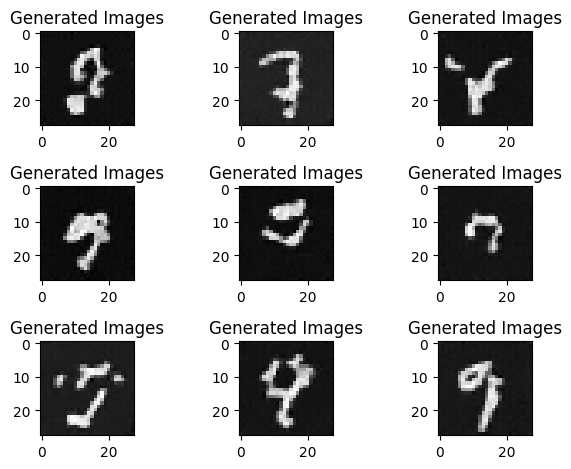

In [ ]:
# inference_unet.py
"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script performs the sampling given the trained UNet model
"""
from tqdm import trange

import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Prepare model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 100
    model = ConditionalUNet().to(device)
    model.load_state_dict(torch.load("unet_mnist.pth"))
    process = DiffusionProcess()

    # Sampling
    xt = torch.randn(batch_size, 1, 28, 28)
    digit_to_sample = torch.Tensor([9]).to(dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for t in trange(999, -1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(device), time.to(device), digit_to_sample)  # predict noise
            xt = process.inverse(xt, et.cpu(), t)

    labels = ["Generated Images"] * 9

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.tight_layout()
        plt.imshow(xt[i][0], cmap="gray", interpolation="none")
        plt.title(labels[i])
    plt.show()
